✅ Dataset loaded from S3


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:44:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     28931
           1       0.87      0.82      0.84     11069

    accuracy                           0.92     40000
   macro avg       0.90      0.89      0.89     40000
weighted avg       0.92      0.92      0.92     40000



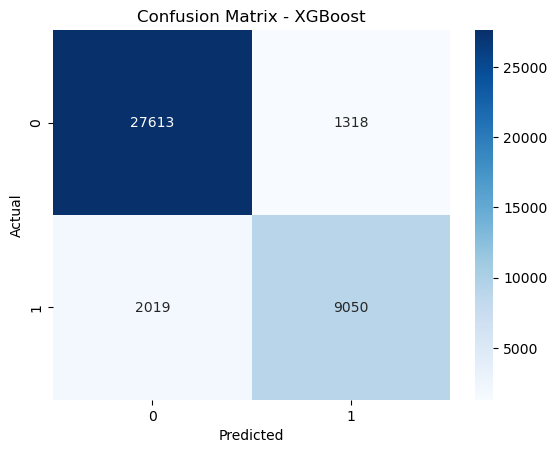

✅ Model saved to S3 at s3://test-bucket-05-ak/cvee_poc/models/xgb_model.pkl
✅ Predictions saved to S3 at s3://test-bucket-05-ak/cvee_poc/output/predictions_with_columns.csv


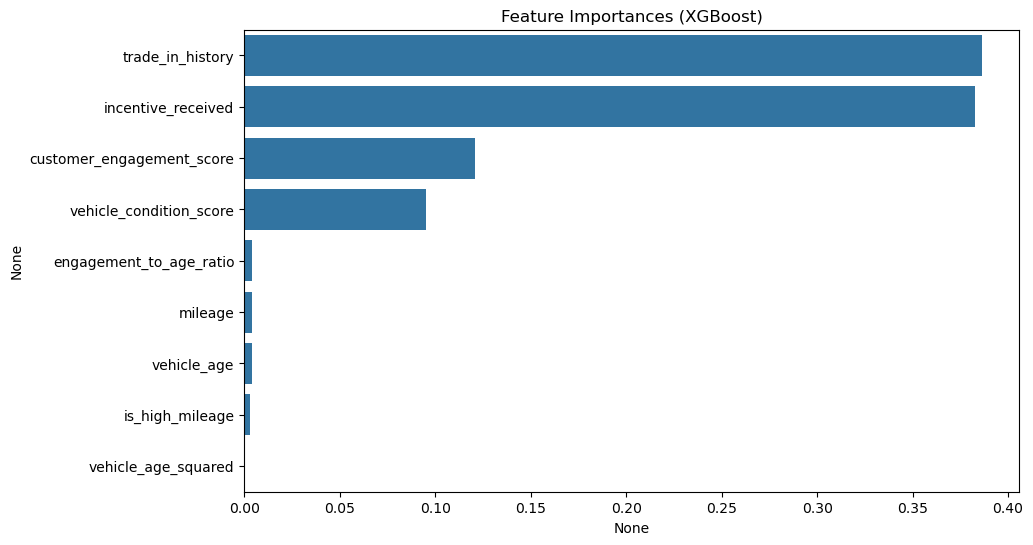

In [8]:
# 📦 Imports
import pandas as pd
import numpy as np
import boto3
import joblib
import os
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 🔐 AWS Configuration (optional if running in AWS environment with IAM roles)
s3 = boto3.client('s3')
bucket_name = 'test-bucket-05-ak'
input_key = 'cvee_poc/input/exchange_dataset_enhanced.csv'
model_key = 'cvee_poc/models/xgb_model.pkl'
output_key = 'cvee_poc/output/predictions_with_columns.csv'

# 📥 Load Dataset from S3
s3_path = f's3://{bucket_name}/{input_key}'
df = pd.read_csv(s3_path)
print("✅ Dataset loaded from S3")

# 🛠️ Optional Feature Engineering
if 'customer_age' in df.columns and 'customer_engagement_score' in df.columns:
    df['engagement_to_age_ratio'] = df['customer_engagement_score'] / (df['customer_age'] + 1)

# 🧼 Handle Missing Values
df.dropna(inplace=True)

# 🧠 Features and Target
X = df.drop('exchange', axis=1)
y = df['exchange']

# 🧪 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 🚀 Train XGBoost Model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)


# 🔍 Predictions
y_pred = model.predict(X_test)

# 📊 Evaluation
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# 🧮 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# 💾 Save Model to S3 as Pickle
model_file = '/tmp/xgb_model.pkl'
joblib.dump(model, model_file)
s3.upload_file(model_file, bucket_name, model_key)
print(f"✅ Model saved to S3 at s3://{bucket_name}/{model_key}")

# 📝 Add predictions to original test DataFrame
X_test_copy = X_test.copy()
X_test_copy['actual'] = y_test.values
X_test_copy['predicted'] = y_pred

# 📝 Save Predictions to S3
csv_buffer = StringIO()
X_test_copy.to_csv(csv_buffer, index=False)
s3.put_object(Bucket=bucket_name, Key=output_key, Body=csv_buffer.getvalue())
print(f"✅ Predictions saved to S3 at s3://{bucket_name}/{output_key}")

# 📈 Optional: Feature Importance Plot
importances = model.feature_importances_
feat_names = X.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importances (XGBoost)")
plt.show()


Top 5 Features: ['trade_in_history', 'incentive_received', 'customer_engagement_score', 'vehicle_condition_score', 'engagement_to_age_ratio']


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:44:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.93      0.96      0.94     28931
           1       0.87      0.82      0.85     11069

    accuracy                           0.92     40000
   macro avg       0.90      0.89      0.89     40000
weighted avg       0.92      0.92      0.92     40000


📊 Classification Report (Top 5 Features):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     28931
           1       0.87      0.82      0.85     11069

    accuracy                           0.92     40000
   macro avg       0.90      0.89      0.89     40000
weighted avg       0.92      0.92      0.92     40000



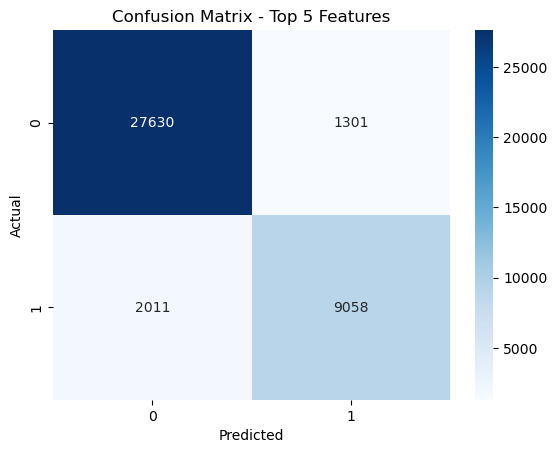

✅ Model (Top 5) saved to S3 at s3://test-bucket-05-ak/cvee_poc/models/xgb_model.pkl
✅ Predictions (Top 5) saved to S3 at s3://test-bucket-05-ak/cvee_poc/output/predictions_with_columns.csv


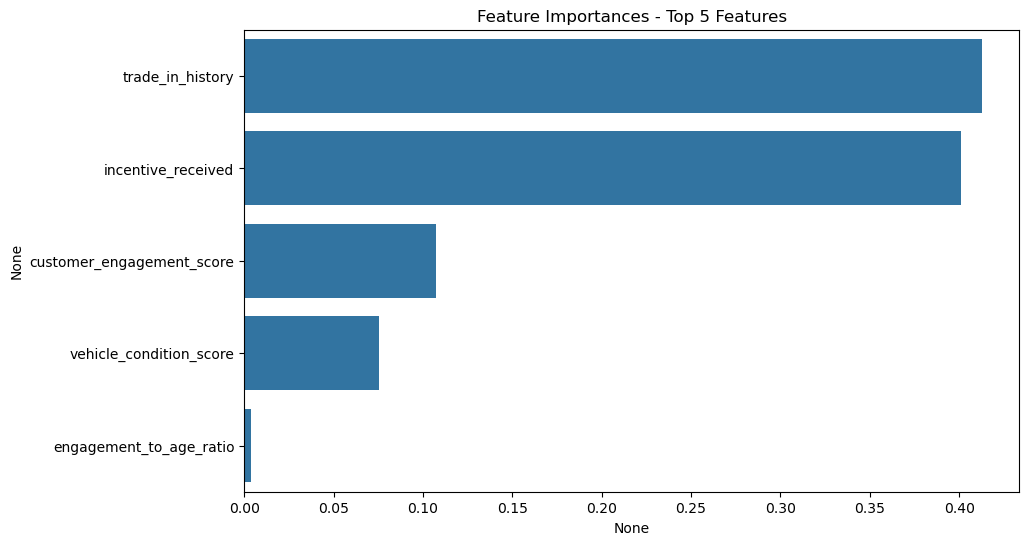

In [9]:
# training and predicting again using important features

# getting top 5 features
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
top_5_features = feat_imp.head(5).index.tolist()
print("Top 5 Features:", top_5_features)

# Filter your dataset using these top 5 features
X_train_top5 = X_train[top_5_features]
X_test_top5 = X_test[top_5_features]

 # Retrain your model using only these features
model_top5 = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_top5.fit(X_train_top5, y_train)

y_pred_top5 = model_top5.predict(X_test_top5)
print(classification_report(y_test, y_pred_top5))

# 📊 Evaluation (Top 5 features)
print("\n📊 Classification Report (Top 5 Features):")
print(classification_report(y_test, y_pred_top5))

# 🧮 Confusion Matrix
cm = confusion_matrix(y_test, y_pred_top5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Top 5 Features")
plt.show()

# 💾 Save Model to S3 as Pickle
model_file = '/tmp/xgb_model_top5.pkl'
joblib.dump(model_top5, model_file)
s3.upload_file(model_file, bucket_name, model_key)
print(f"✅ Model (Top 5) saved to S3 at s3://{bucket_name}/{model_key}")

# 📝 Add predictions to original test DataFrame (with top 5 features)
X_test_copy = X_test_top5.copy()
X_test_copy['actual'] = y_test.values
X_test_copy['predicted'] = y_pred_top5

# 📝 Save Predictions to S3
csv_buffer = StringIO()
X_test_copy.to_csv(csv_buffer, index=False)
s3.put_object(Bucket=bucket_name, Key=output_key, Body=csv_buffer.getvalue())
print(f"✅ Predictions (Top 5) saved to S3 at s3://{bucket_name}/{output_key}")

# 📈 Feature Importance Plot (Top 5 features only)
importances = model_top5.feature_importances_
feat_names = X_test_top5.columns
feat_imp = pd.Series(importances, index=feat_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title("Feature Importances - Top 5 Features")
plt.show()

In [4]:
importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feat_imp)


trade_in_history             0.386454
incentive_received           0.382527
customer_engagement_score    0.121067
vehicle_condition_score      0.095218
engagement_to_age_ratio      0.003965
mileage                      0.003936
vehicle_age                  0.003848
is_high_mileage              0.002985
vehicle_age_squared          0.000000
dtype: float32


In [7]:
top_features = feat_imp.head(5).index.tolist()
X = X[top_features]
print(X)

        trade_in_history  incentive_received  customer_engagement_score  \
0                      1                   1                         25   
1                      0                   1                         14   
2                      0                   1                         83   
3                      0                   0                         69   
4                      0                   1                         72   
...                  ...                 ...                        ...   
199995                 0                   1                         28   
199996                 0                   1                         83   
199997                 1                   1                         62   
199998                 1                   1                         25   
199999                 0                   0                         15   

        vehicle_condition_score  engagement_to_age_ratio  
0                            23         